<a href="https://colab.research.google.com/github/xeniia-nikole/Python_detecting_objects/blob/master/searching_in_image_by_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
! pip install opencv-python
import cv2
import os
import time
import numpy as np
from IPython.display import Image 

path = '/content/somebodies.jpg'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
image_new = None
image = cv2.imread(path)

# Load names of classes and get random colors
labels = open('/content/coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [83]:
# Give the configuration and weight files for the model and load the network.
net = cv2.dnn.readNet('/content/yolov3.weights',
                '/content/yolov3.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

In [84]:
def searching(image, output_layers):
    admissible_crossing = 0.7
    confidence_level = 0.01
    global image_new
    H, W = image.shape[:2]

    boxes = []
    confidences = []
    probabilities = []

    for layer in output_layers:
        probability = layer[5:]
        index_max_probability = np.argmax(probability)
        confidence = probability[index_max_probability]
        if confidence > confidence_level:
            x, y, w, h = layer[:4] * np.array([W, H, W, H])
            p0 = int(x - w//2), int(y - h//2)
            p1 = int(x + w//2), int(y + h//2)
            boxes.append([*p0, int(w), int(h)])
            confidences.append(float(confidence))
            probabilities.append(index_max_probability)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_level, admissible_crossing)

    if len(indices) > 0:
        for i in indices.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in colors[probabilities[i]]]
            image_new = cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[probabilities[i]], confidences[i])
            image_new = cv2.putText(image_new, text, (x, y - 5), cv2.FONT_HERSHEY_TRIPLEX, 2, color, 1)

In [85]:
height, width, depth = image.shape

blob = cv2.dnn.blobFromImage(image, 1/255.0, (608, 608), swapRB = True, crop=False)
net.setInput(blob)

# determine the output layer
layers_names = net.getLayerNames()
unconnected_layers = net.getUnconnectedOutLayersNames()
output_layers = np.vstack(net.forward(unconnected_layers))
searching(image, output_layers)

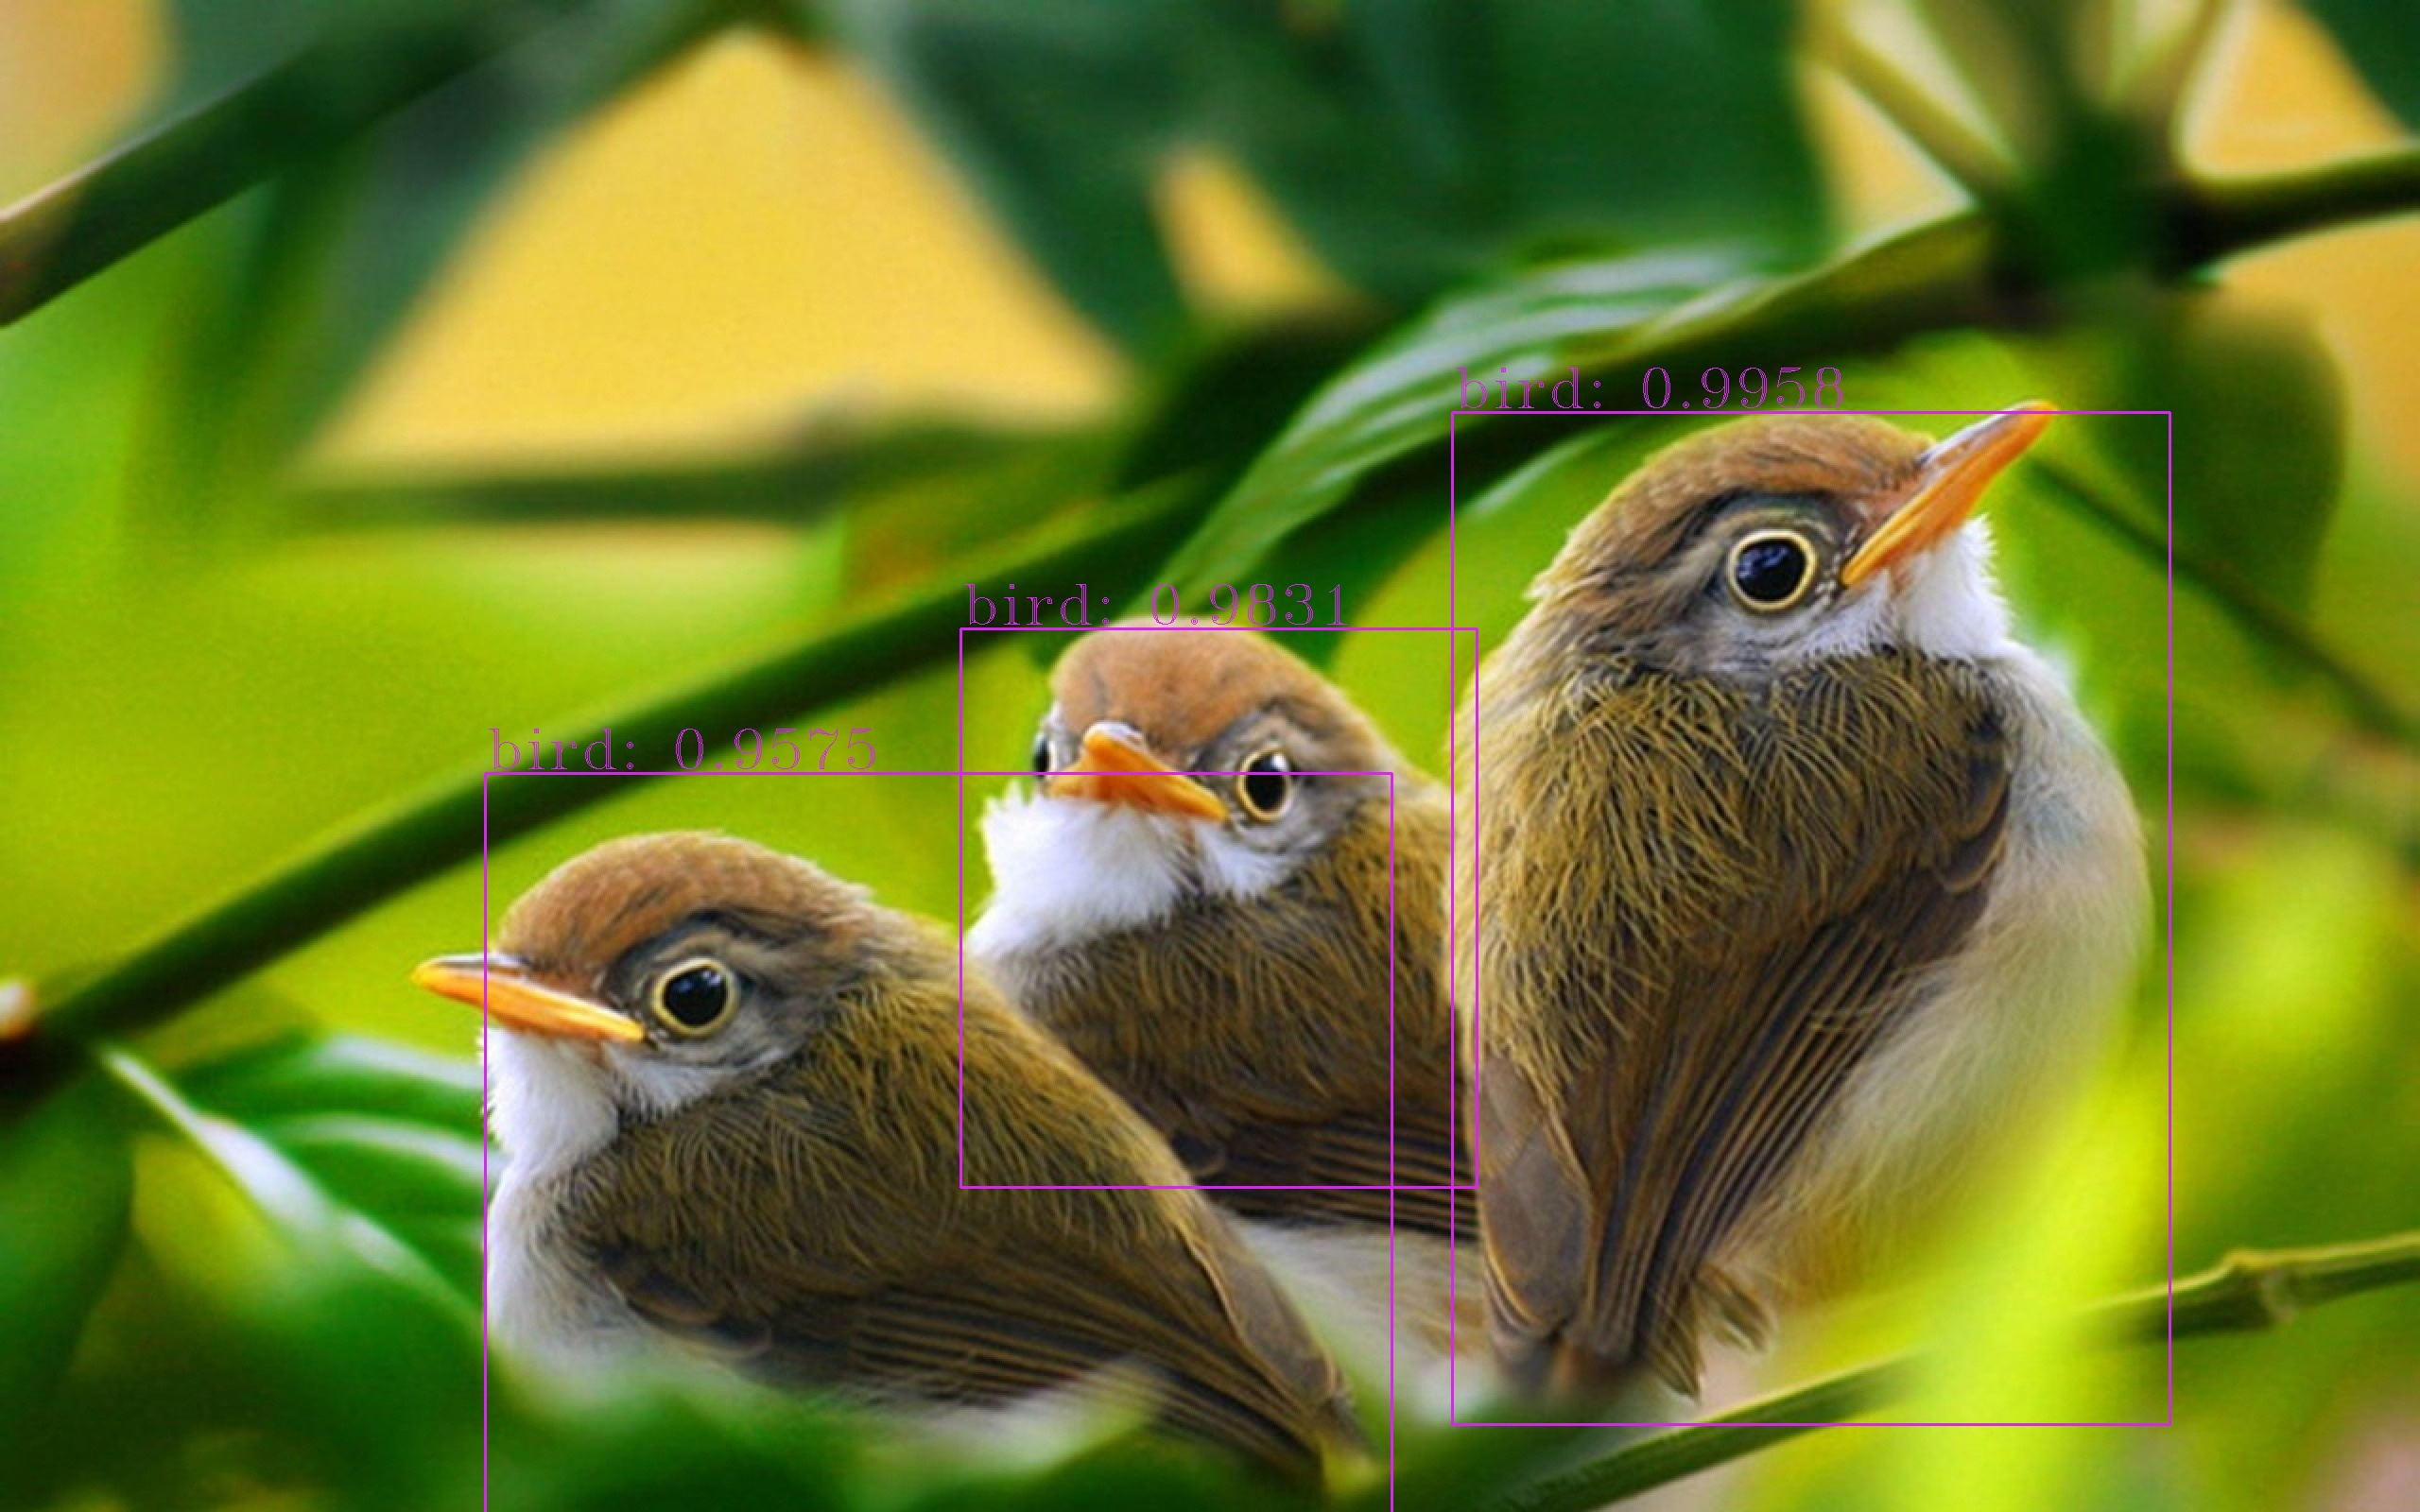

In [86]:
cv2.imwrite('/content/image_with_objects.jpg',image_new)
Image('/content/image_with_objects.jpg')

In [87]:
cv2.destroyAllWindows()
os.remove('image_with_objects.jpg')